<a href="https://colab.research.google.com/github/antonvandike/Algoritmos-Geneticos/blob/main/Libro_Eyal_Wirsansky/Handson_chapter_6_3_himmelblau_s_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Solucion del problema de la funcion de himmelblau con sharing y niching

###Configuraciones y definiciones

In [1]:
pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.1 MB/s eta 0:00:00


#Solucion del problema del agente de ventas viajero

###Configuraciones y definiciones

In [2]:
## Paso 1: Modulos

from deap import base
from deap import creator
from deap import tools

import random as rd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import elitism
import math

In [3]:
# Constantes del problema:

DIMENSIONS = 2  # number of dimensions
BOUND_LOW, BOUND_UP = -5.0, 5.0  # boundaries for all dimensions

In [4]:
# sharing constants:
DISTANCE_THRESHOLD = 0.1
SHARING_EXTENT = 5.0

In [5]:
## Paso 2: Parametros del problema

# Contenido del problema del agente viajero

POPULATION_SIZE = 300     # Tamaño de la poblacion de individuos
P_CROSSOVER     =  0.9    # Probabilidad de cruza
P_MUTATION      =  0.5    # Probabilidad de mutación

MAX_GENERATIONS = 300     # Maximo numero de generaciones (condición de termino)

In [6]:
HALL_OF_FAME_SIZE = 30

In [7]:
CROWDING_FACTOR = 20.0  # Factor de aglomeracion para cruza y mutacion

In [8]:
## Paso 3: Elementos aleatorios

RANDOM_SEED = 42          # Comunmente cuando se experimenta con un codigo
rd.seed(RANDOM_SEED)      # se corre el problema con los mismos parametros
                          # para repetir y compara resultados

In [9]:
## Paso 4: Declarando el cromosoma
toolbox = base.Toolbox()

def randomFloat(low, up):
    return [rd.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

In [10]:
toolbox.attrFloat()

[1.3942679845788373, -4.74989244777333]

In [11]:
## Paso 5: Crear la funcion de aptitud (FITNESS)

# Se indica maximizacion y un solo peso
creator.create('FitnessMax', base.Fitness, weights = (1.0,))

In [12]:
## Paso 6: Crear la funcion de  aptitud del individuo

creator.create("Individual", list, fitness=creator.FitnessMax)

In [13]:
## Paso 7: Declarar el operador para generador de individuos

toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat)

In [14]:
## Paso 8: Declarar el operador para generar la poblacion

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [15]:
## Paso 9: Definir función para calcular la aptitud
# 'Inverted' Himmelblau function as the given individual's fitness:
def himmelblauInverted(individual):
    x = individual[0]
    y = individual[1]
    f = (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
    return 2000.0 - f,  # return a tuple

In [16]:
## Paso 10: Declarar el operador de evaluacion

toolbox.register("evaluate", himmelblauInverted)

In [17]:
# wraps the tools.selTournament() with fitness sharing
# same signature as tools.selTournament()
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):

    # get orig fitnesses:
    origFitnesses = [ind.fitness.values[0] for ind in individuals]

    # apply sharing to each individual:
    for i in range(len(individuals)):
        sharingSum = 1

        # iterate over all other individuals
        for j in range(len(individuals)):
            if i != j:
                # calculate eucledean distance between individuals:
                distance = math.sqrt(
                    ((individuals[i][0] - individuals[j][0]) ** 2) + ((individuals[i][1] - individuals[j][1]) ** 2))

                if distance < DISTANCE_THRESHOLD:
                    sharingSum += (1 - distance / (SHARING_EXTENT * DISTANCE_THRESHOLD))

        # reduce fitness accordingly:
        individuals[i].fitness.values = origFitnesses[i] / sharingSum,

    # apply original tools.selTournament() using modified fitness:
    selected = tools.selTournament(individuals, k, tournsize, fit_attr)

    # retrieve original fitness:
    for i, ind in enumerate(individuals):
        ind.fitness.values = origFitnesses[i],

    return selected

In [18]:
## Paso 11: Declarar los operadores geneticos

toolbox.register("select", selTournamentWithSharing, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, indpb=1.0/DIMENSIONS)

###Evolucionando la solución

In [19]:
def himmelblau_problem():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with elitism:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print("- Best solutions are:")
    for i in range(HALL_OF_FAME_SIZE):
        print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

    # plot solution locations on x-y plane:
    plt.figure(1)
    globalMaxima = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584458, -1.848126]]
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*population), marker='.', color='blue', zorder=0)    # plot solution locations on x-y plane:

    # plot best solutions locations on x-y plane:
    plt.figure(2)
    plt.scatter(*zip(*globalMaxima), marker='x', color='red', zorder=1)
    plt.scatter(*zip(*hof.items), marker='.', color='blue', zorder=0)

    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    plt.figure(3)
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')

    plt.show()



gen	nevals	max    	avg    
0  	300   	1999.92	1862.58
1  	258   	1999.92	1912.98
2  	258   	1999.92	1923.31
3  	259   	1999.92	1933.72
4  	257   	1999.98	1940.87
5  	262   	1999.98	1935.04
6  	253   	1999.98	1945.11
7  	258   	1999.98	1948.03
8  	260   	1999.98	1942.7 
9  	259   	1999.98	1939.97
10 	253   	1999.98	1944.35
11 	257   	1999.98	1948.72
12 	260   	1999.98	1945.71
13 	261   	1999.98	1946.48
14 	262   	1999.98	1950.38
15 	255   	1999.99	1954.13
16 	253   	1999.99	1952.95
17 	264   	1999.99	1944.09
18 	259   	1999.99	1946.95
19 	262   	1999.99	1946.51
20 	255   	1999.99	1947.72
21 	260   	1999.99	1947.34
22 	263   	1999.99	1949.54
23 	253   	1999.99	1950.46
24 	259   	1999.99	1955.62
25 	260   	1999.99	1951.02
26 	251   	1999.99	1957.56
27 	259   	1999.99	1957.44
28 	251   	1999.99	1953.7 
29 	264   	1999.99	1949.97
30 	255   	1999.99	1954.7 
31 	249   	1999.99	1957.9 
32 	244   	1999.99	1958.1 
33 	252   	1999.99	1954.26
34 	249   	1999.99	1953.43
35 	257   	1999.99	1944.54
3

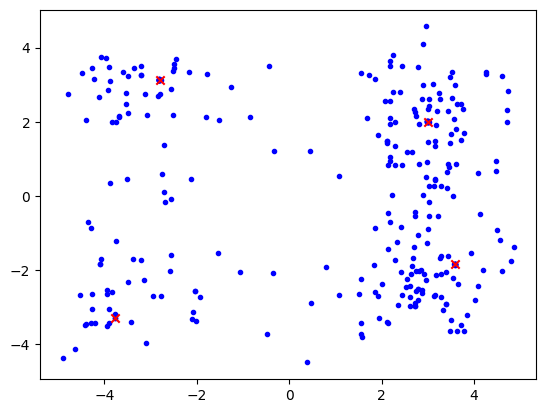

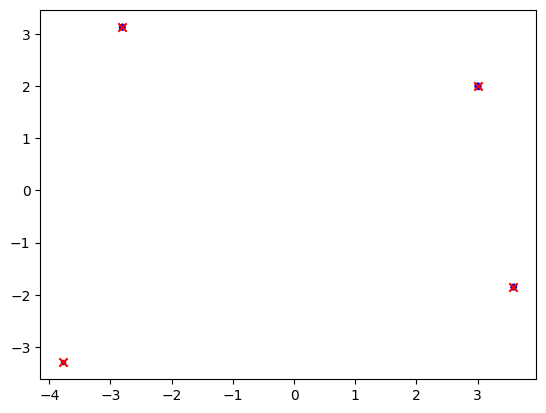

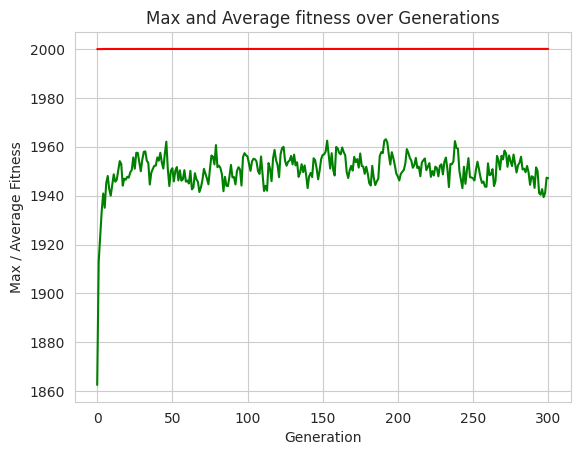

In [20]:
himmelblau_problem()